In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_probability as tfp
import matplotlib.pyplot as plt

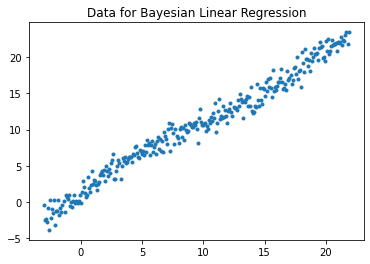

In [ ]:
def generate_data(n=100, sd=1, xlims=[-3,6*np.pi+3], seed=1,
                  f = lambda x: 1 + x + np.sin(x/3)*(x>0)*(x<6*np.pi)):
    '''
    This version more accurately reflects the functional relationship?
    `np.sin(x/3)*(x>0)*(x<6*np.pi))` is not intuitive feature engineering
    and without specifying this correctly the linear specification is wrong
    and subsequently the normality assumptions of the model are incorrect.

    Are you sure you want to introduce correlated errors into the analysis?
    '''

    np.random.seed(seed)
    x = np.linspace(*xlims, n)
    y = f(x) + np.random.normal(0, sd, n)
    return x,y

x, y = generate_data(300)
plt.plot(x, y, '.')
plt.title("Data for Bayesian Linear Regression")
plt.show()

## Selection prior model

Set up model $x \sim N(b_1m_1+b_2m_2, 1)$

Maybe can try $y \sim N(b_1m_1x +b_2m_2, 1)$ after this

In [ ]:
np.random.seed(1)

m1 = np.random.normal(loc=0, scale=1) # Is this prior important here? Are m1, m2 observable? Can cancel out if so.
m2 = np.random.normal(loc=0, scale=1)
b1 = np.random.binomial(1, p=0.5) # masked 
b2 = np.random.binomial(1, p=0.5) # masked

# generate 10 samples

n = 3
x = np.random.normal(loc = b1 * m1 + b2 * m2, scale=1, size=n)
x

array([-0.52817175, -1.07296862,  0.86540763])

In [ ]:
m1, m2

(1.6243453636632417, -0.6117564136500754)

In [ ]:
from scipy.stats import norm

p = 0.5

# p(x | m1, m2) = Sum_{b1, b2} p(x | b1, b2, m1, m2) integrating over b1, b2
def marginal_m(x, m1, m2):
  return (1-p) * (1-p) * norm.pdf(x, loc=0) + \
          p * (1-p) * norm.pdf(x, loc=m1) + \
          p * (1-p) * norm.pdf(x, loc=m2) + \
          p * p * norm.pdf(x, loc=m1+m2)

def prior_b(b):
  return (p ** b) * ((1 - p) ** (1 - b))

# p(b1, b2 | x, m1, m2) = p(b1) p(b2) \Pi likelihood
def posterior_b(sample_b, x, m1, m2):
  b1, b2 = sample_b
  joint = prior_b(b1) * prior_b(b2) * np.exp(np.sum(np.log( norm.pdf(x, loc=b1*m1 + b2*m2) ))) ## exp sum log for numeric stability
  return joint

def metropolis(sample_b, sample_b_new, posterior, x, m1, m2):
  accept_prob = posterior(sample_b_new, x, m1, m2) / posterior(sample_b, x, m1, m2)
  if np.random.uniform() < accept_prob:
    return sample_b_new # accept
  else:
    return sample_b     # reject


n_samples = 100

# Metropolis algorithm
def draw_samples(n_samples, x, m1, m2):
  init_b1 = np.random.binomial(1, p)
  init_b2 = np.random.binomial(1, p)
  b_curr = (init_b1, init_b2)

  samples = []
  for i in range(n_samples):
    # draw from q(b_new | b), symetric transition

    # m1_new = np.random.normal(loc=m1_curr, 1)
    # m2_

    b1_new = np.random.binomial(1, p)
    b2_new = np.random.binomial(1, p)
    b_new = (b1_new, b2_new)

    # acceptance process
    b_next = metropolis(b_curr, b_new, posterior_b, x, m1, m2)
    samples.append(b_next)
    b_curr = b_next
  return samples

In [ ]:
marginal_m(x, m1, m2)

array([0.2264064 , 0.1597163 , 0.27552241])

In [ ]:
for i in [0, 1]:
  for j in [0, 1]:
    print("posterior for ", i, j)
    print(posterior_b((i, j), x, m1, m2))

posterior for  0 0
0.5358920563878846
posterior for  0 1
0.4794564730670444
posterior for  1 0
0.003099069451154454
posterior for  1 1
0.05464913208028932


In [ ]:
metropolis((0,0), (0,1), posterior_b, x, m1, m2)

(0, 1)

In [ ]:
samples = draw_samples(n_samples, x, m1, m2)
print(samples)

[(1, 0), (0, 1), (0, 1), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 1), (0, 1), (0, 1), (0, 0), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (1, 1), (1, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 0), (0, 0), (1, 1), (0, 0), (0, 1), (0, 1), (0, 0), (0, 0), (0, 0), (0, 1), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (0, 0), (0, 0), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 1), (0, 1), (0, 1), (0, 0), (0, 0), (0, 0), (0, 0), (0, 1), (0, 1), (1, 1), (0, 0), (0, 1), (0, 1), (0, 1), (0, 0), (0, 1), (0, 1), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]


<BarContainer object of 4 artists>

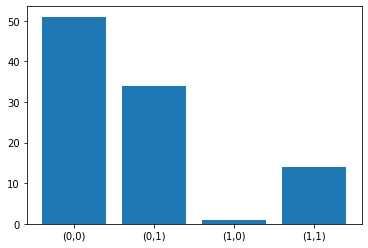

In [ ]:
b00 = 0
b01 = 0
b10 = 0
b11 = 0

for s in samples:
  if s == (0, 0): 
    b00 += 1
  if s == (0, 1):
    b01 += 1
  if s == (1, 0):
    b10 += 1
  if s == (1, 1):
    b11 += 1
plt.bar(x=["(0,0)", "(0,1)", "(1,0)", "(1,1)"], height = [b00, b01, b10, b11])

In [ ]:
# True
print(b1, b2)

0 0


## Dropout vs GP

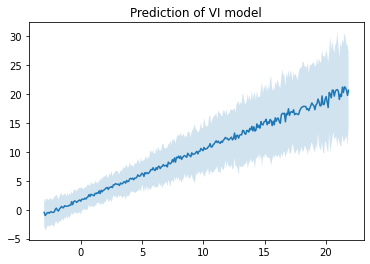

In [ ]:
# MC-Dropout

def neg_loglik(target, pred_distribution):
  return -pred_distribution.log_prob(target)
batch_size = 32

inputs = layers.Input(shape=(1,))
features = layers.Dense(20)(inputs)
features = layers.Dropout(0.1)(features, training=True)

params = layers.Dense(1)(features)
# params = layers.Dropout(0.1)(params)

pred_distribution = tfp.layers.DistributionLambda(
    lambda params: tfp.distributions.Normal(loc=params[:,0:1], scale=1)
)(params)
model_Dropout = tf.keras.Model(inputs=inputs, outputs=pred_distribution)
model_Dropout.compile(tf.keras.optimizers.Adam(), loss=neg_loglik)
hist = model_Dropout.fit(x, y, epochs=500, verbose=0, batch_size=batch_size)

# test for Dropout
x_test = x
predictions = []
for i in range(50):
  predictions.append(model_Dropout.predict(x_test))
predictions = np.array(predictions)
mu = np.squeeze(np.mean(predictions, axis=0))
std = np.squeeze(np.std(predictions, axis=0))

plt.plot(x_test, mu, label="Mean prediction")
plt.fill_between(x_test, mu - 2*std, mu + 2 * std, alpha=0.2)
plt.title("Prediction of VI model")
plt.show()

In [ ]:
std.mean()

2.2058666

### Property of $p$

As the dropout probability increases,

* (aleatoric) uncertainty not constant, large when far from 0. # TODO: adding a bias term to the initial data might help. 

* output uncertainty increases

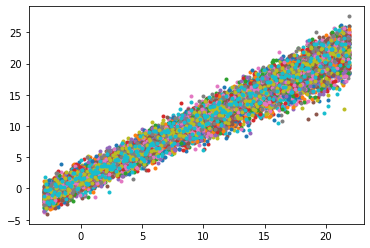

In [ ]:
for i in range(50):
  plt.plot(x_test, predictions[i], '.')

### Gaussian process using PYMC

In [ ]:
import pymc3 as pm

X = x[:, np.newaxis]

with pm.Model() as gp_model:
  
  # using squared exponential covariance function
  # predictive uncertainty increases far away from the data
  sq_exp = pm.gp.cov.ExpQuad(input_dim=1, ls=1)

  gp = pm.gp.Marginal(cov_func=sq_exp)

  sigma = pm.HalfCauchy('sigma', beta=5)
  lik = gp.marginal_likelihood('y', X=X, y=y, noise=sigma)
  
  mp = pm.find_MAP()

In [ ]:
with gp_model:
  pred = gp.conditional('pred', X)

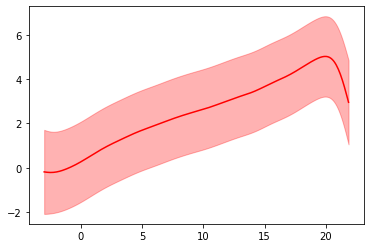

In [ ]:
# with gp_model:
#   pred_samples = pm.sample_posterior_predictive([mp], var_names=[pred], samples=2000)

mu, var = gp.predict(X, point=mp, diag=True)
std = np.sqrt(var)

fig = plt.figure()
ax = fig.gca()

# plt.plot(x, y)
# plt.plot true non-linearity

plt.plot(X, mu, "r", label="pred mean")
plt.fill_between(X.squeeze(), mu - 2*std, mu + 2 * std, alpha=0.3, color="r")

plt.show()